In [1]:
import time
import os
import math
import pickle
import skimage.io
import numpy as np
import tensorflow as tf
import skimage as ski
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

DATA_DIR = './cifar/'
SAVE_DIR = "./out_cifar/"
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
NUM_CLASSES = 10
BATCH_SIZE = 196
MAX_EPOCHS = 50
WEIGHT_DECAY = 1e-4

In [2]:
def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def to_one_hot(class_index, class_num=10):
    one_hot = [0] * class_num
    one_hot[class_index] = 1
    return one_hot

def iterate_minibatches(X, Y_, batch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, X.shape[0] - batch_size + 1, batch_size):
        indices_range = indices[start_idx:start_idx + batch_size]
        yield X[indices_range], Y_[indices_range]

def get_trainable_weights():
    weights = []
    for var in tf.trainable_variables():
        if "/kernel:0" not in var.name: 
            continue
        weights.append(var)
    return weights

In [3]:
def load_cifar(data_dir):
    classes_pickle = os.path.join(DATA_DIR, 'batches.meta')
    class_names = np.array(unpickle(classes_pickle)['label_names'])

    train_x = np.ndarray((0, IMG_HEIGHT * IMG_WIDTH * NUM_CHANNELS), dtype=np.float32)
    train_y = []
    for i in range(1, 6):
        subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
        train_x = np.vstack((train_x, subset['data']))
        train_y += subset['labels']
    train_x = train_x.reshape((-1, NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH)).transpose(0,2,3,1)
    train_y = np.array(train_y, dtype=np.int32)

    subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
    test_x = subset['data'].reshape((-1, NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH)).transpose(0,2,3,1).astype(np.float32)
    test_y = np.array(subset['labels'], dtype=np.int32)

    valid_size = 5000
    train_x, train_y = shuffle_data(train_x, train_y)
    valid_x = train_x[:valid_size, ...]
    valid_y = train_y[:valid_size, ...]
    train_x = train_x[valid_size:, ...]
    train_y = train_y[valid_size:, ...]
    data_mean = train_x.mean((0,1,2))
    data_std = train_x.std((0,1,2))
    
    train_x = (train_x - data_mean) / data_std
    valid_x = (valid_x - data_mean) / data_std
    test_x = (test_x - data_mean) / data_std

    train_x = train_x.reshape([-1, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS])
    valid_x = valid_x.reshape([-1, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS])
    test_x = test_x.reshape([-1, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS])
    train_y = np.array(list(map(to_one_hot, train_y)))
    valid_y = np.array(list(map(to_one_hot, valid_y)))
    test_y = np.array(list(map(to_one_hot, test_y)))
    return train_x, train_y, valid_x, valid_y, test_x, test_y, data_mean, data_std, class_names

In [5]:
def conv_layer(inputs, filters=32, kernel_size=[5, 5], 
               activation=tf.nn.relu, regularizer=tf.contrib.layers.l2_regularizer(scale=WEIGHT_DECAY), name=None):
    return tf.layers.conv2d(inputs, filters, kernel_size, padding='same', 
                            activation=activation, kernel_regularizer=regularizer,
                            kernel_initializer=tf.variance_scaling_initializer(), name=name)

def max_pool_layer(inputs, pool_size=[2, 2], strides=2, name=None):
    return tf.layers.max_pooling2d(inputs, pool_size, strides, padding='same', name=name)

def fc_layer(input, units, activation=tf.nn.relu, regularizer=tf.contrib.layers.l2_regularizer(scale=WEIGHT_DECAY), name=None):
    return tf.layers.dense(input, units, activation, kernel_regularizer=regularizer, 
                           kernel_initializer=tf.variance_scaling_initializer(), name=name)

In [6]:
def draw_conv_filters(session, layer, epoch, step, name, save_dir):
    weights = session.run(layer).copy()
    num_filters = weights.shape[3]
    num_channels = weights.shape[2]
    k = weights.shape[0]
    assert weights.shape[0] == weights.shape[1]
    weights -= weights.min()
    weights /= weights.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    img = np.zeros([height, width, num_channels])
    for i in range(num_filters):
        r = int(i / cols) * (k + border)
        c = int(i % cols) * (k + border)
        img[r:r+k,c:c+k,:] = weights[:,:,:,i]
    filename = '%s_epoch_%02d_step_%06d.png' % (name, epoch, step)
    ski.io.imsave(os.path.join(save_dir, filename), img)

def draw_image(img, mean, std):
    img *= std
    img += mean
    img = img.astype(np.uint8)
    ski.io.imshow(img)
    ski.io.show()

In [7]:
def build_dnn(inputs):
    input_layer = tf.reshape(inputs, [-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS])
    conv1 = conv_layer(input_layer, 16, name="conv1")
    pool1 = max_pool_layer(conv1, name="pool1")

    conv2 = conv_layer(pool1, 32, name="conv2")
    pool2 = max_pool_layer(conv2, name="pool2")
    
    flat_pool2 = tf.contrib.layers.flatten(pool2)

    fc1 = fc_layer(flat_pool2, 256, name="fc1")
    fc2 = fc_layer(fc1, 128, name="fc2")
    logits = fc_layer(fc2, NUM_CLASSES, activation=None, regularizer=None, name="logits")
    return logits

In [8]:
def accuracy_my(confusion):
    return confusion.trace()/confusion.sum()

def precision_my(confusion, averaging="macro"):
    size = confusion.shape[0]
    tw_ms = [twoway_confusion_matrix(confusion, i) for i in range(size)]
    if averaging == "macro":        
        precision=0.0
        for tw in tw_ms:
            if tw[0, 0] != 0:  
                precision += tw[0, 0]/(tw[0, 0] + tw[0, 1])
        return precision/size
    else:
        conf = np.zeros((2,2)).astype(float)
        for tw in tw_ms:
            conf += tw
        conf /= size
        return conf[0, 0]/(conf[0, 0] + conf[0, 1])

def recall_my(confusion, averaging="macro"):
    size = confusion.shape[0]
    tw_ms = [twoway_confusion_matrix(confusion, i) for i in range(size)]
    if averaging == "macro":        
        precision=0.0
        for tw in tw_ms:
            if tw[0, 0] != 0:  
                precision += tw[0, 0]/(tw[0, 0] + tw[1, 0])
        return precision/size
    else:
        conf = np.zeros((2,2)).astype(float)
        for tw in tw_ms:
            conf += tw
        conf /= size
        return conf[0, 0]/(conf[0, 0] + conf[1, 0])

def twoway_confusion_matrix(cm, i):
    tp = cm[i, i]
    fn = np.sum(cm[i,:]) - tp
    fp = np.sum(cm[:,i]) - tp
    tn = np.sum(cm) - fp - fn - tp
    return np.matrix([[tp, fp], [fn, tn]]).astype(int)
    
def evaluate(sess, logits, loss, input_x, input_y, class_names, should_print=False):
    output = logits.eval(feed_dict={x: input_x, y_: input_y}, session=sess)
    y_true = np.argmax(output, 1)
    y_pred = np.argmax(input_y, 1)

    y_pred = np.asarray(y_pred)
    y_true = np.asarray(y_true)
    if should_print:
        all_confusion = confusion_matrix(y_true, y_pred)
        print("confusion matrix:")
        print(all_confusion)
        for i in range(all_confusion.shape[0]):
            tw = twoway_confusion_matrix(all_confusion, i)
            print('class %s, precision %g, recall %g' % (class_names[i], precision_my(tw, averaging="macro"), recall_my(tw, averaging="macro")))
            
    current_loss = loss.eval(feed_dict={x: input_x, y_: input_y}, session=sess)
    current_acc = (y_pred == y_true).sum() / input_x.shape[0]
    return current_loss, current_acc

In [9]:
tf.reset_default_graph()
train_x, train_y, valid_x, valid_y, test_x, test_y, mean, std, class_names = load_cifar(DATA_DIR)
x = tf.placeholder(tf.float32, [None, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

y_conv = build_dnn(x)
weights = get_trainable_weights()[:-1]
sample_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)
err_loss = tf.reduce_mean(sample_loss)
reg_loss = sum(map(lambda w : tf.nn.l2_loss(w), weights))
loss = err_loss + WEIGHT_DECAY * reg_loss

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, 500, 0.95, staircase=True)
train_step = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=global_step)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_examples = train_x.shape[0]
num_batches = num_examples // BATCH_SIZE
print_step = 5
draw_step = 100
print("Loaded!")

Loaded!


In [10]:
plot_data = {}
plot_data['train_loss'] = []
plot_data['valid_loss'] = []
plot_data['train_acc'] = []
plot_data['valid_acc'] = []
plot_data['lr'] = []
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(1, MAX_EPOCHS + 1):
    for (j, batch) in enumerate(iterate_minibatches(train_x, train_y, BATCH_SIZE)):
        train_step.run(feed_dict={x: batch[0], y_: batch[1]}, session=sess)
        if j % print_step == 0:
            batch_loss = loss.eval(feed_dict={x: batch[0], y_: batch[1]}, session=sess)
            print('epoch %d, step %d/%d, batch loss %g, learning rate: %g' % (epoch, j, num_batches, batch_loss, sess.run(learning_rate)), end="\r", flush=True)
        if j % draw_step == 0:
            draw_conv_filters(sess, weights[0], epoch, j, "conv1", SAVE_DIR)

    print("", flush=True)

    train_loss, train_acc = evaluate(sess, y_conv, loss, train_x, train_y, class_names)
    print('train loss %g, train accuracy %g' % (train_loss, train_acc))
    valid_loss, valid_acc = evaluate(sess, y_conv, loss, valid_x, valid_y, class_names)    
    print('validation loss %g, validation accuracy %g' % (valid_loss, valid_acc))
    plot_data['train_loss'] += [train_loss]
    plot_data['valid_loss'] += [valid_loss]
    plot_data['train_acc'] += [train_acc]
    plot_data['valid_acc'] += [valid_acc]
    plot_data['lr'] += [sess.run(learning_rate)]

test_loss, test_acc = evaluate(sess, y_conv, loss, test_x, test_y, class_names, should_print=True)
print('test loss %g, test accuracy %g' % (test_loss, test_acc))

c:\users\gulan_filip\appdata\local\programs\python\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 225/229, batch loss 1.36839, learning rate: 0.01
train loss 1.36555, train accuracy 0.515378
validation loss 1.3935, validation accuracy 0.504
epoch 2, step 225/229, batch loss 1.18033, learning rate: 0.011
train loss 1.14517, train accuracy 0.598511
validation loss 1.19654, validation accuracy 0.5682
epoch 3, step 225/229, batch loss 1.05993, learning rate: 0.00955
train loss 0.975114, train accuracy 0.664222
validation loss 1.08261, validation accuracy 0.6252
epoch 4, step 225/229, batch loss 1.01371, learning rate: 0.00955
train loss 0.825699, train accuracy 0.720511
validation loss 0.977865, validation accuracy 0.6624
epoch 5, step 225/229, batch loss 0.774729, learning rate: 0.009025
train loss 0.734694, train accuracy 0.751756
validation loss 0.961603, validation accuracy 0.677
epoch 6, step 225/229, batch loss 0.596805, learning rate: 0.009025
train loss 0.696277, train accuracy 0.760689
validation loss 1.00854, validation accuracy 0.6656
epoch 7, step 225/229, bat

confusion matrix:
[[760  21  56  23  27  15   7  18  65  37]
 [ 18 817   9   6   4   5   3   3  35  86]
 [ 52   8 606  87  77  59  49  27  19   6]
 [ 31  10  66 518  65 174  61  49   9  13]
 [ 21   1  94  56 662  44  38  65   7   5]
 [  5   2  60 185  51 598  35  56   5  14]
 [  9  13  52  61  46  35 788  11   6   9]
 [  5   1  32  36  56  53   4 756   5  19]
 [ 61  29   9  12   9   5   5   4 820  33]
 [ 38  98  16  16   3  12  10  11  29 778]]
class airplane, precision 0.855914, recall 0.865056
class automobile, precision 0.904149, recall 0.899111
class bird, precision 0.784196, recall 0.781667
class cat, precision 0.733274, recall 0.732444
class deer, precision 0.81457, recall 0.812611
class dog, precision 0.773386, recall 0.776056
class frog, precision 0.870707, recall 0.880556
class horse, precision 0.877394, recall 0.866278
class ship, precision 0.905415, recall 0.900722
class truck, precision 0.872419, recall 0.876056
test loss 2.39318, test accuracy 0.7103


In [12]:
def plot_training_progress(save_dir, data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

    linewidth = 2
    legend_size = 10
    train_color = 'm'
    val_color = 'c'

    num_points = len(data['train_loss'])
    x_data = np.linspace(1, num_points, num_points)
    ax1.set_title('Cross-entropy loss')
    ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
    ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
    ax1.legend(loc='upper right', fontsize=legend_size)
    ax2.set_title('Average class accuracy')
    ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
    ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
    ax2.legend(loc='upper left', fontsize=legend_size)
    ax3.set_title('Learning rate')
    ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
    ax3.legend(loc='upper left', fontsize=legend_size)

    save_path = os.path.join(save_dir, 'training_plot.pdf')
    print('Plotting in: ', save_path)
    plt.savefig(save_path)

plot_training_progress(SAVE_DIR, plot_data)

Plotting in:  ./out_cifar/training_plot.pdf


correct class: ship
predictions: ['truck' 'automobile' 'airplane'] [  1.00000000e+00   1.48580559e-09   1.35804229e-10]


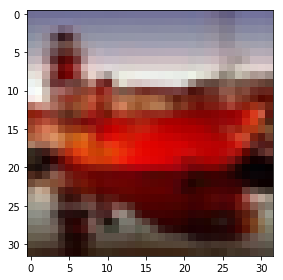

correct class: frog
predictions: ['cat' 'dog' 'horse'] [  5.97181737e-01   4.02817547e-01   7.20216235e-07]


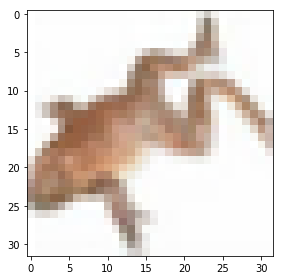

correct class: frog
predictions: ['horse' 'bird' 'dog'] [ 0.97788417  0.01221178  0.00990413]


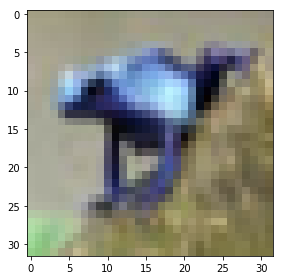

correct class: dog
predictions: ['truck' 'horse' 'cat'] [  8.48819315e-01   1.51171789e-01   7.89780825e-06]


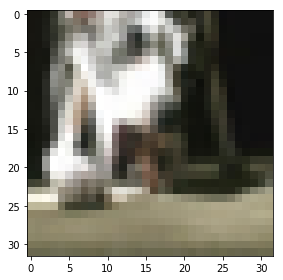

correct class: ship
predictions: ['automobile' 'airplane' 'truck'] [  1.00000000e+00   3.20389196e-14   2.92548476e-14]


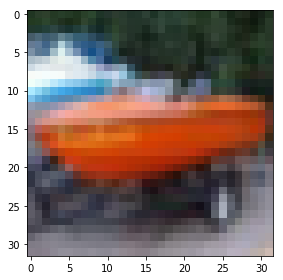

correct class: automobile
predictions: ['horse' 'truck' 'bird'] [ 0.90279597  0.06078819  0.02292658]


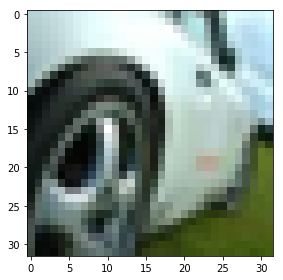

correct class: cat
predictions: ['frog' 'cat' 'bird'] [  1.00000000e+00   2.14685331e-16   6.37926585e-17]


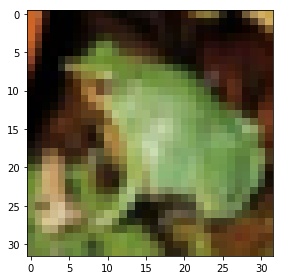

correct class: dog
predictions: ['frog' 'bird' 'deer'] [  1.00000000e+00   4.14224965e-09   1.84848289e-10]


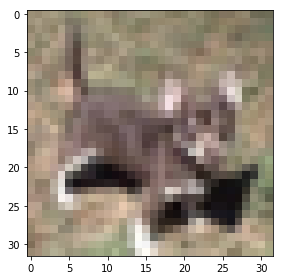

correct class: dog
predictions: ['truck' 'ship' 'cat'] [  1.00000000e+00   1.98132812e-11   3.10780416e-12]


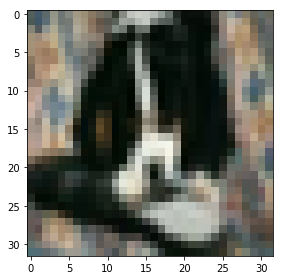

correct class: horse
predictions: ['deer' 'frog' 'airplane'] [  1.00000000e+00   4.41302177e-08   3.43791884e-09]


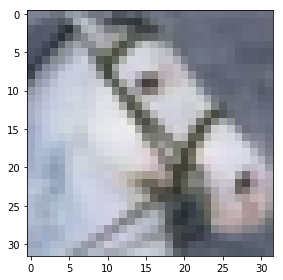

correct class: bird
predictions: ['dog' 'cat' 'horse'] [  8.90417933e-01   1.09379172e-01   2.02863215e-04]


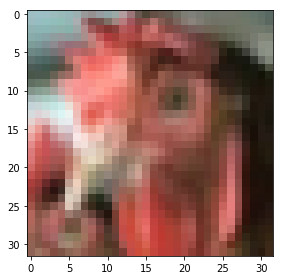

correct class: cat
predictions: ['frog' 'dog' 'cat'] [  1.00000000e+00   4.18680593e-15   1.32824094e-15]


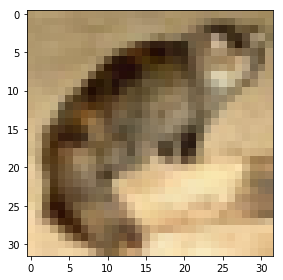

correct class: truck
predictions: ['cat' 'dog' 'frog'] [  9.99888301e-01   8.97472564e-05   1.17816908e-05]


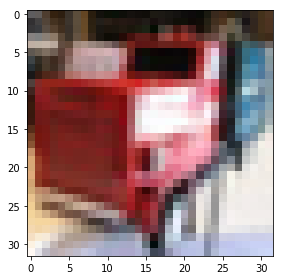

correct class: airplane
predictions: ['truck' 'frog' 'ship'] [  1.00000000e+00   2.03488804e-09   3.81279452e-10]


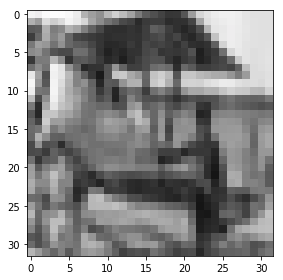

correct class: cat
predictions: ['deer' 'horse' 'cat'] [  1.00000000e+00   7.91575667e-15   2.29949879e-15]


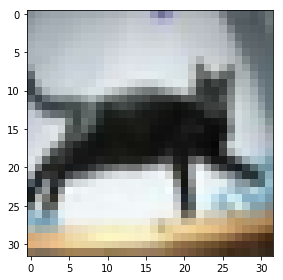

correct class: truck
predictions: ['airplane' 'cat' 'dog'] [  9.99866962e-01   1.31319510e-04   1.70967587e-06]


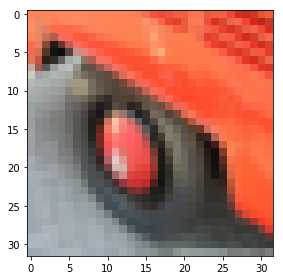

correct class: deer
predictions: ['dog' 'cat' 'horse'] [  9.04009104e-01   9.59908962e-02   1.17284186e-11]


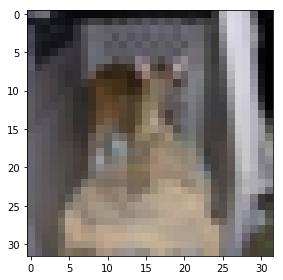

correct class: cat
predictions: ['horse' 'deer' 'dog'] [  9.83736694e-01   1.62206367e-02   4.26742045e-05]


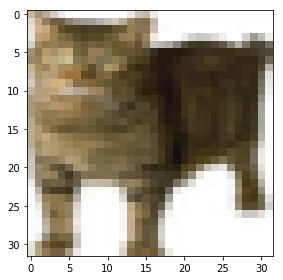

correct class: bird
predictions: ['dog' 'horse' 'cat'] [  9.92405355e-01   7.59454304e-03   4.82975828e-08]


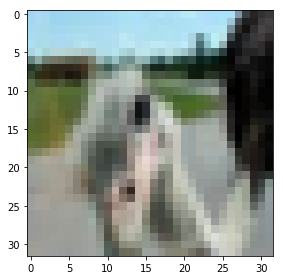

correct class: truck
predictions: ['horse' 'bird' 'cat'] [  1.00000000e+00   2.70131650e-09   1.50324961e-11]


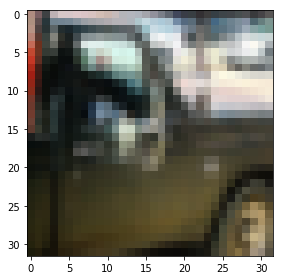

In [11]:
def draw_worst_samples(sess, sample_loss, logits, input_x, input_y):
    outputs = tf.nn.softmax(logits).eval(feed_dict={x: input_x, y_: input_y}, session=sess)
    per_sample_losses = sample_loss.eval(feed_dict={x: input_x, y_: input_y}, session=sess)
    
    psl_indexed = []
    for i, sample_loss in enumerate(per_sample_losses):
        psl_indexed.append((i, sample_loss))
    
    psl_indexed = sorted(psl_indexed, key=lambda pair: pair[1], reverse=True)
    top20 = psl_indexed[:20]
    for (index, _) in top20:
        output = outputs[index]
        predictions = np.argsort(-output)
        correct_class_index = np.argmax(input_y[index])
        print("correct class:", class_names[correct_class_index])
        print("predictions:", class_names[predictions[:3]], output[predictions[:3]])
        draw_image(input_x[index], mean, std)
        
draw_worst_samples(sess, sample_loss, y_conv, test_x, test_y)